In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


## Task1: Basics

In [4]:
import torch
from torchvision import models
model = models.resnet34(weights='IMAGENET1K_V1')
device = torch.device("cpu")
model.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
from torchvision import transforms, datasets

mean_norms = [0.485, 0.456, 0.406]
std_norms  = [0.229, 0.224, 0.225]
tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

dataset = datasets.ImageFolder(root='./TestDataSet', transform=tf)
loader  = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

In [6]:
import json
import torch

# 1. Read in your JSON
with open('./TestDataSet/labels_list.json', 'r') as f:
    entries = json.load(f)   

# 2. resolve the global index and the corresponding name
imagenet_ids = []    # save 401, 402, …
imagenet_names = []  # save 'accordion', 'acoustic guitar', …
for s in entries:
    idx_str, name = s.split(': ', 1)
    imagenet_ids.append(int(idx_str))
    imagenet_names.append(name)

# 3. Get the order of class names automatically generated by ImageFolder
class_names = dataset.classes          # e.g. ['accordion','acoustic guitar',…]，length = 100
class_to_folder_idx = dataset.class_to_idx  # {'accordion':0, 'acoustic guitar':1,…}



# 5. Build the “folder idx → global idx” mapping.
folder2global = {i: imagenet_ids[i] for i in range(len(imagenet_ids))}

all_top1 = 0
all_top5 = 0
total = 0

with torch.no_grad():
    for imgs, tg in loader:
        imgs = imgs.to(device)
        # Maps folder idx's 0-99 to ImageNet idx's 0-999.
        gt = torch.tensor([folder2global[int(x)] for x in tg], device=device)

        logits = model(imgs)
        _, pred5 = logits.topk(5, dim=1, largest=True, sorted=True)

        # pred5 is [B,5], each entry is a global idx
        correct = pred5.eq(gt.view(-1,1))
        all_top1 += correct[:, :1].sum().item()
        all_top5 += correct.sum().item()
        total += imgs.size(0)

print(f"Top‑1 Acc: {all_top1/total*100:.2f}%")
print(f"Top‑5 Acc: {all_top5/total*100:.2f}%")

Top‑1 Acc: 76.00%
Top‑5 Acc: 94.20%


## Task2: Pixel-wise attacks

In [7]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Adversarial Test Set 1 – Top-1 Accuracy: 21.00%
Adversarial Test Set 1 – Top-5 Accuracy: 43.60%


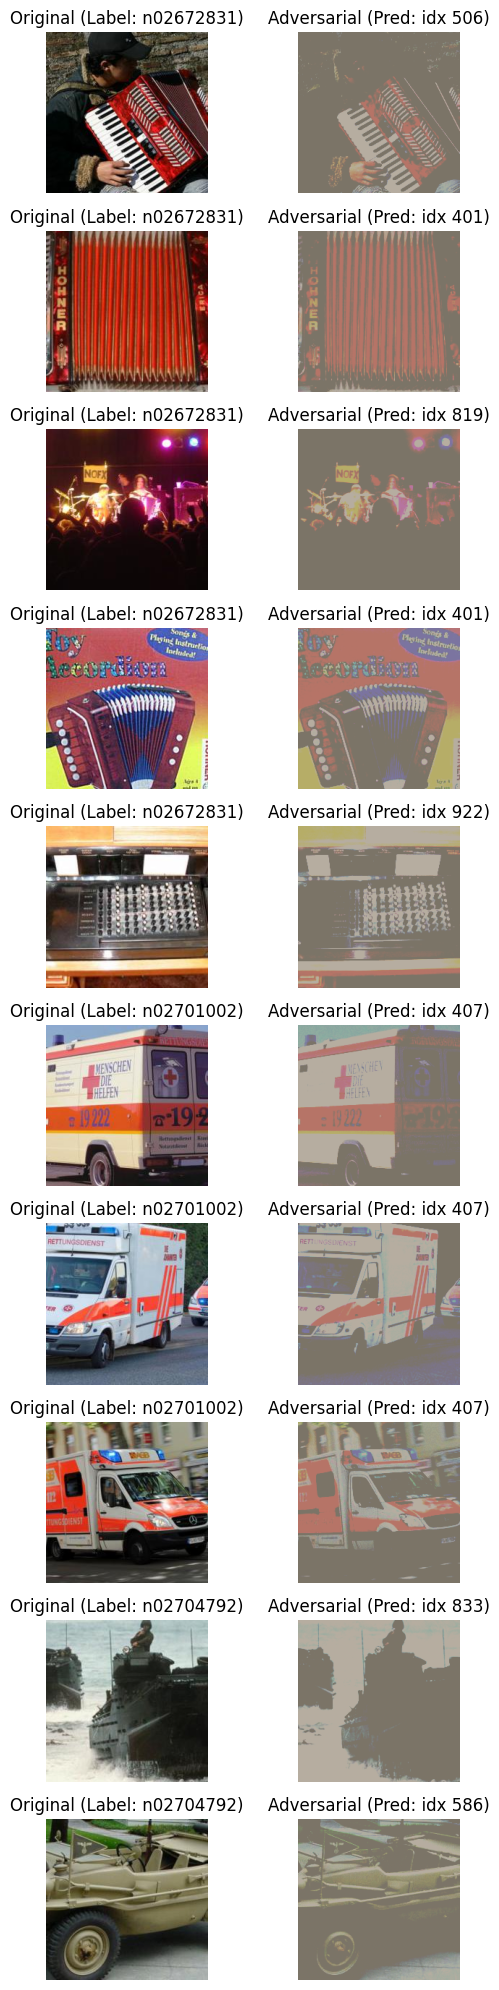

In [15]:
import torch
import torch.nn.functional as F
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
from torchvision.utils import save_image

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=tensor.device)[:, None, None]
    std  = torch.tensor([0.229, 0.224, 0.225], device=tensor.device)[:, None, None]
    return (tensor * std + mean).clamp(0, 1)

def show_examples(orig, adv, labels, preds):
    fig, axes = plt.subplots(len(orig), 2, figsize=(6, len(orig)*2))
    for i in range(len(orig)):
        axes[i, 0].imshow(orig[i].detach().permute(1,2,0).numpy())
        axes[i, 0].set_title(f"Original (Label: {labels[i]})")
        axes[i, 1].imshow(adv[i].detach().permute(1,2,0).numpy())
        axes[i, 1].set_title(f"Adversarial (Pred: {preds[i]})")
        for j in range(2):
            axes[i,j].axis('off')
    plt.tight_layout()
    plt.show()

epsilon = 0.042  # Enhanced Disturbance Intensity

adv_examples = []
all_top1 = 0
all_top5 = 0
total = 0

# Task 2 Confrontation dataset storage paths
OUT_ROOT = Path("./AdversarialSet1")
OUT_ROOT.mkdir(exist_ok=True)

# Create subcategories for each category according to the ImageFolder convention.
for cls in dataset.classes:         
    (OUT_ROOT / cls).mkdir(parents=True, exist_ok=True)
    
for batch_idx, (images, labels) in enumerate(loader):
    images = images.to(device)
    images.requires_grad = True

    # Real labels (global idx)
    global_targets = torch.LongTensor([folder2global[int(x)] for x in labels]).to(device)

    # Forward propagation & calculating loss
    outputs = model(images)
    loss = F.cross_entropy(outputs, global_targets)
    model.zero_grad()
    loss.backward()

    # FGSM attack
    data_grad = images.grad.data
    perturbed_images = fgsm_attack(images, epsilon, data_grad)

    # Model Adversarial Evaluation
    with torch.no_grad():
        adv_outputs = model(perturbed_images)
        _, pred5 = adv_outputs.topk(5, dim=1)
        correct = pred5.eq(global_targets.view(-1, 1))
        all_top1 += correct[:, :1].sum().item()
        all_top5 += correct.sum().item()
        total += images.size(0)

    # Visualize the first few sets of samples
    if batch_idx < 2:
        for i in range(5):
            orig_img = denormalize(images[i].cpu()).clamp(0,1)
            adv_img = denormalize(perturbed_images[i].detach().cpu()).clamp(0,1)
            label_str = dataset.classes[labels[i]]
            pred_str = f"idx {pred5[i][0].item()}"
            adv_examples.append((orig_img, adv_img, label_str, pred_str))

    # -------- Save Confrontation Sample PNG --------
    adv_imgs_01 = denormalize(perturbed_images.detach())  # Inverse normalized to [0,1]
    
    for i in range(adv_imgs_01.size(0)):
        cls_name = dataset.classes[labels[i]]
        file_name = f"img{batch_idx:04d}_{i:02d}.png"
        save_path = OUT_ROOT / cls_name / file_name
        save_image(adv_imgs_01[i].cpu(), save_path)
    # ---------------------------------

# Output final accuracy
print(f"Adversarial Test Set 1 – Top-1 Accuracy: {all_top1/total*100:.2f}%")
print(f"Adversarial Test Set 1 – Top-5 Accuracy: {all_top5/total*100:.2f}%")

# Visualization Comparison Chart
show_examples(
    [x[0] for x in adv_examples],
    [x[1] for x in adv_examples],
    [x[2] for x in adv_examples],
    [x[3] for x in adv_examples]
)

## Task3: Improved attacks

In [9]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


Adversarial Test Set 2 – Top-1 Accuracy: 0.40%
Adversarial Test Set 2 – Top-5 Accuracy: 6.80%


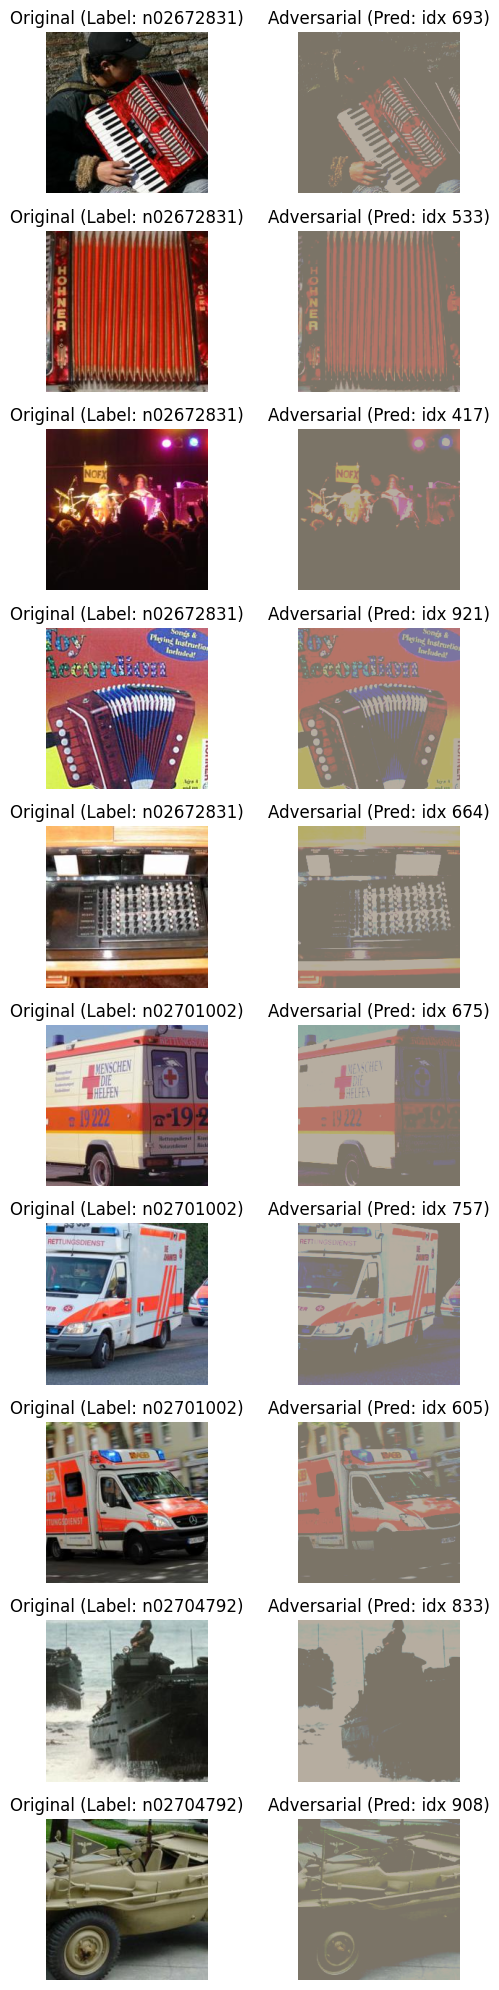

In [17]:
from pathlib import Path
from torchvision.utils import save_image

def denormalize(t):
    mean = torch.tensor([0.485,0.456,0.406], device=t.device)[:,None,None]
    std  = torch.tensor([0.229,0.224,0.225], device=t.device)[:,None,None]
    return (t * std + mean).clamp(0,1)

def iterative_fgsm_attack(image, epsilon, alpha, iters, model, target):
    perturbed_image = image.clone().detach()
    for i in range(iters):
        perturbed_image.requires_grad = True
        outputs = model(perturbed_image)
        loss = F.cross_entropy(outputs, target)
        model.zero_grad()
        loss.backward()
        grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + alpha * grad.sign()
        eta = torch.clamp(perturbed_image - image, min=-epsilon, max=epsilon)
        perturbed_image = torch.clamp(image + eta, 0, 1).detach()
    return perturbed_image

epsilon = 0.02  
alpha = epsilon / 5  
iters = 10  

adv_examples = []
all_top1 = 0
all_top5 = 0
total = 0

OUT_ROOT = Path("./AdversarialSet2")        
OUT_ROOT.mkdir(exist_ok=True)

# Consistent with the original test set category, build subfolders
for cls in dataset.classes:
    (OUT_ROOT/cls).mkdir(parents=True, exist_ok=True)

for batch_idx, (images, labels) in enumerate(loader):
    images = images.to(device)
    global_targets = torch.LongTensor([folder2global[int(x)] for x in labels]).to(device)

    perturbed_images = iterative_fgsm_attack(images, epsilon, alpha, iters, model, global_targets)

    # Model Adversarial Evaluation
    with torch.no_grad():
        adv_outputs = model(perturbed_images)
        _, pred5 = adv_outputs.topk(5, dim=1)
        correct = pred5.eq(global_targets.view(-1, 1))
        all_top1 += correct[:, :1].sum().item()
        all_top5 += correct.sum().item()
        total += images.size(0)

    # Visualize the first few sets of samples
    if batch_idx < 2:
        for i in range(5):
            orig_img = denormalize(images[i].cpu()).clamp(0,1)
            adv_img = denormalize(perturbed_images[i].detach().cpu()).clamp(0,1)
            label_str = dataset.classes[labels[i]]
            pred_str = f"idx {pred5[i][0].item()}"
            adv_examples.append((orig_img, adv_img, label_str, pred_str))

        # ----------- Preservation of antagonistic samples -----------
    adv_imgs_01 = denormalize(perturbed_images.detach())   # Inverse normalization to [0,1]
    
    for i in range(adv_imgs_01.size(0)):
        cls_name = dataset.classes[labels[i]]
        file_name = f"img{batch_idx:04d}_{i:02d}.png"
        save_image(adv_imgs_01[i].cpu(), OUT_ROOT/cls_name/file_name)
    # -----------------------------------


# Output final accuracy
print(f"Adversarial Test Set 2 – Top-1 Accuracy: {all_top1/total*100:.2f}%")
print(f"Adversarial Test Set 2 – Top-5 Accuracy: {all_top5/total*100:.2f}%")

# Visualization Comparison Chart
show_examples(
    [x[0] for x in adv_examples],
    [x[1] for x in adv_examples],
    [x[2] for x in adv_examples],
    [x[3] for x in adv_examples]
)


In [3]:
import os
print("AdvSet2 images:", sum(len(f) for _,_,f in os.walk("./AdversarialSet2")))

AdvSet2 images: 500


## Task4: Patch Attacks

In [19]:
import torch
import torch.nn.functional as F
import random
from pathlib import Path
from torchvision.utils import save_image

def denorm(t):
    mean = torch.tensor([0.485,0.456,0.406], device=t.device)[:,None,None]
    std  = torch.tensor([0.229,0.224,0.225], device=t.device)[:,None,None]
    return (t*std + mean).clamp(0,1)

OUT3 = Path("./AdversarialSet3")      # Task-4 Patch attack 
OUT3.mkdir(exist_ok=True)
for cls in test_dataset.classes:      # same order as original dataset
    (OUT3/cls).mkdir(parents=True, exist_ok=True)

def patch_attack_single(model, x, y, epsilon=0.3, patch_size=32,
                        steps=10, alpha=None, targeted=False, device='cuda'):
    """
    x: torch.Tensor [C,H,W], values in [0,1]
    y: scalar label
    targeted: if True, pushes toward target_label=(y+1)%num_classes
    returns: x_adv [C,H,W], (x0,y0) top‐left coords of the patch
    """
    model.eval()
    if alpha is None:
        alpha = epsilon / steps

    num_classes = model.fc.out_features
    target = ((y + 1) % num_classes) if targeted else y
    target = torch.tensor([target], device=device)

    x_orig = x.to(device).unsqueeze(0)
    x_adv = x_orig.clone().detach()
    _, C, H, W = x_adv.shape

    # pick a random top‐left corner
    x0 = random.randint(0, W - patch_size)
    y0 = random.randint(0, H - patch_size)

    # build mask
    mask = torch.zeros_like(x_adv)
    mask[:, :, y0:y0+patch_size, x0:x0+patch_size] = 1.0

    for _ in range(steps):
        x_adv.requires_grad_(True)
        logits = model(x_adv)
        loss = F.cross_entropy(logits, target)
        # untargeted: maximize loss → ascend; targeted: minimize → descend
        grad_sign = torch.sign(torch.autograd.grad(
            ( -loss if not targeted else loss ), x_adv, retain_graph=False, create_graph=False
        )[0])

        # update only in patch
        x_adv = x_adv.detach() + alpha * (grad_sign * mask)
        # project total perturbation back into ε‐ball
        delta = torch.clamp(x_adv - x_orig, -epsilon, epsilon)
        x_adv = torch.clamp(x_orig + delta, 0.0, 1.0).detach()

    return x_adv.squeeze(0).cpu(), (x0, y0)

In [20]:
### Cell 2: generate “Adversarial Test Set 3” (500 images) with progress bar

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm   # ⬅️ import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# reuse your existing test transform & dataset
test_dataset = dataset = datasets.ImageFolder(root='./TestDataSet', transform=tf)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

adv_images, adv_labels, adv_patches = [], [], []

for i, (img, lbl) in enumerate(tqdm(test_loader, total=500, desc="Generating Adv Set 3")):
    if i >= 500: break                           

    adv_img, (x0, y0) = patch_attack_single(
        model, img[0], lbl.item(),
        epsilon=0.3, patch_size=32,
        steps=15, alpha=0.02,
        targeted=True, device=device
    )

    # ========= Added: Instant Save PNG =========
    cls_name  = test_dataset.classes[lbl.item()]
    file_name = f"img{i:04d}.png"
    save_image(adv_img, OUT3/cls_name/file_name)       
    # ======================================

    adv_images.append(adv_img)        
    adv_labels.append(lbl)
    adv_patches.append((x0, y0))

adv_images = torch.stack(adv_images)
adv_labels = torch.cat(adv_labels)
adv_dataset3 = TensorDataset(adv_images, adv_labels)
torch.save(adv_dataset3, 'AdversarialTestSet3.pt')
adv_loader3 = DataLoader(adv_dataset3, batch_size=64, shuffle=False)

Generating Adv Set 3: 100%|███████████████████| 500/500 [05:00<00:00,  1.67it/s]


In [21]:
import os
print("PNG saved:", sum(len(f) for _,_,f in os.walk(OUT3)))

PNG saved: 500


In [22]:
### Cell 3: evaluate ResNet‑34 on Adversarial Test Set 3 (with proper mapping)

# reset counters
all_top1 = all_top5 = total = 0

model.eval()
with torch.no_grad():
    for imgs, tg in adv_loader3:
        # move to device
        imgs = imgs.to(device)
        # tg is your 0–99 folder idx; map it into the 0–999 global ImageNet idx
        gt = torch.tensor([folder2global[int(x)] for x in tg],
                          device=device)

        # forward + top‑5
        logits = model(imgs)
        _, pred5 = logits.topk(5, dim=1, largest=True, sorted=True)

        # pred5 is [B,5] of global idxs
        correct = pred5.eq(gt.view(-1,1))
        all_top1 += correct[:, :1].sum().item()
        all_top5 += correct.sum().item()
        total    += imgs.size(0)

print(f'Adversarial Test Set 3 → Top‑1: {all_top1/total*100:.2f}%   Top‑5: {all_top5/total*100:.2f}%')

Adversarial Test Set 3 → Top‑1: 39.00%   Top‑5: 58.00%


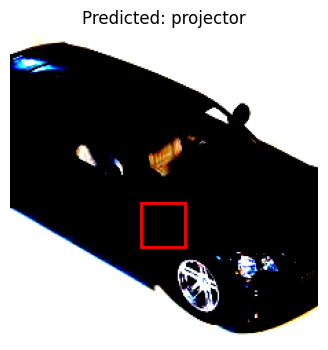

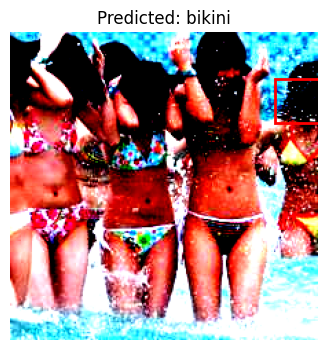

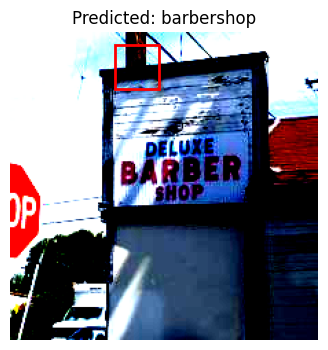

In [23]:
### Cell 4: visualize 3 examples with patch & top‑5 predictions (fixed JSON loading)

import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F

# (re)load idx2label if you haven’t already
with open('imagenet_class_index.json') as f:
    idx2label = {int(k): v[1] for k, v in json.load(f).items()}

# show 3 separate figures
for i in range(3):
    adv_img = adv_images[i]            # your [3,224,224] tensor
    x0, y0 = adv_patches[i]           # top‐left corner of the patch

    # get top‐1 prediction
    logits = model(adv_img.unsqueeze(0).to(device))
    pred = logits.argmax(dim=1).item()
    name = idx2label[pred]

    # plot
    plt.figure(figsize=(4,4))
    plt.imshow(adv_img.permute(1,2,0))
    rect = patches.Rectangle((x0, y0), 32, 32, linewidth=2,
                             edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.title(f"Predicted: {name}")
    plt.axis('off')

plt.show()

In [25]:
pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 55.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]2m2/3 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [26]:
import torch, json, os, pandas as pd
from pathlib import Path
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Same normalization as Task-1
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
plain_tf = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

# 4 copies of the root catalog of the data set
DATASETS = {
    "Original"    : "./TestDataSet",
    "Adv-FGSM"    : "./AdversarialSet1",
    "Adv-PGD10"   : "./AdversarialSet2",
    "Adv-Patch32" : "./AdversarialSet3"
}
BATCH = 32


In [27]:
new_model = models.densenet121(weights="IMAGENET1K_V1").eval().to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /Users/may/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100.0%


In [33]:
@torch.no_grad()
def evaluate(loader, folder2global):
    top1 = top5 = total = 0
    for imgs, lbl in tqdm(loader, leave=False):
        imgs = imgs.to(device)
        logits = new_model(imgs)
        _, pred5 = logits.topk(5, dim=1)
        gt = torch.LongTensor([folder2global[int(x)] for x in lbl]).to(device)
        correct = pred5.eq(gt.view(-1,1))
        top1 += correct[:, 0].sum().item()
        top5 += correct.sum().item()
        total += imgs.size(0)
    return 100*top1/total, 100*top5/total


# 载模型后 ↓
with open("imagenet_class_index.json") as f:
    wnid2int = {v[0]: int(k) for k, v in json.load(f).items()}

results = {}
for name, path in DATASETS.items():
    ds = datasets.ImageFolder(path, transform=plain_tf)
    ld = DataLoader(ds, batch_size=BATCH, shuffle=False, num_workers=4)
    folder2global = {i: wnid2int[cls] for i, cls in enumerate(ds.classes)}

    top1, top5 = evaluate(ld, folder2global)
    results[name] = (top1, top5)



In [34]:
df = pd.DataFrame(results, index=["Top-1 %", "Top-5 %"]).T.round(2)
display(df)

df.to_csv("task5_transfer_results.csv", index=True)
print("output task5_transfer_results.csv")


,Top-1 %,Top-5 %
Original,74.8,93.6
Adv-FGSM,40.6,66.0
Adv-PGD10,39.2,64.6
Adv-Patch32,46.2,69.4


output task5_transfer_results.csv


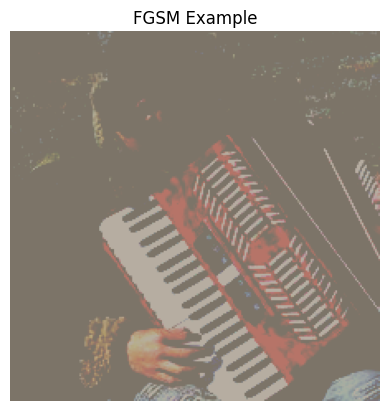

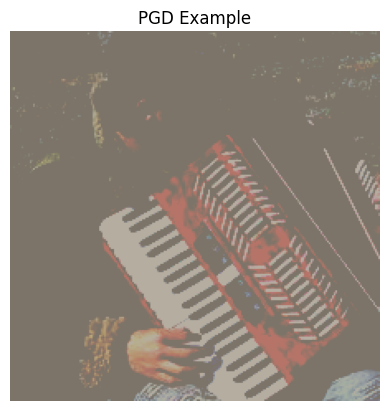

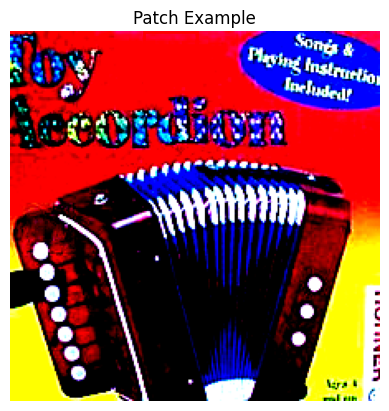

In [46]:
def show_adv_example(root, title, coords=None):
    img_norm,_ = next(iter(DataLoader(datasets.ImageFolder(root, transform=plain_tf),
                                      batch_size=1)))
    img_denorm = (img_norm[0] * std + mean).clamp(0,1)
    plt.imshow(to_pil_image(img_denorm))
    if coords is not None:
        x0,y0 = coords
        plt.gca().add_patch(
            patches.Rectangle((x0,y0), 32, 32,
                              linewidth=2, edgecolor='r', facecolor='none'))
    plt.title(title); plt.axis('off'); plt.show()

show_adv_example("./AdversarialSet1", "FGSM Example")
show_adv_example("./AdversarialSet2", "PGD Example")
show_adv_example("./AdversarialSet3", "Patch Example", coords=(x0,y0))  
